In [1]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats
import sys; sys.path.insert(1, '/home/alessandro/scripts')
import geometry as gm
#import conversion as cnv
#from func_statistics import compute_pdf_nbin, slopes_r_p, slope_time, slope_maps
#from coare_functions import *
import meteo
import lcl
import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background
from plotdistr import fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d
import warnings; warnings.filterwarnings("ignore")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# find data
path = '/media/matteo/DAGOBAH/WRF_EUREC4A/CNT/FEB/01/'
wrf_files = path + 'wrfout_d02_2020-0'
fname_list = sorted(glob.glob(wrf_files + '*'))

In [4]:
minlon = -60.; maxlon = -51.
minlat = 0.; maxlat = 17.

In [5]:
# open data
ds_tot = xr.open_mfdataset(fname_list, concat_dim='Time', combine='nested')

In [6]:
# select domain
mask_lon = (ds_tot.XLONG >= minlon) & (ds_tot.XLONG <= maxlon)
mask_lat = (ds_tot.XLAT >= minlat) & (ds_tot.XLAT <= maxlat)
ds = ds_tot.where(mask_lon & mask_lat, drop=True)

In [7]:
# def lon lat time
lon = ds['XLONG'][0].values
lat = ds['XLAT'][0].values
time = ds['XTIME'].values.astype('<M8[s]')
# land - sea mask
lakemask = ds['LAKEMASK'][0].values
landmask = ds['LANDMASK'][0].values
seamask = 1 - lakemask - landmask
seamask[seamask==0] = np.nan
# def extended land-sea mask
seamask_nocoast = seamask.copy(); seamask_island0 = seamask.copy()
seamask_island0[:int(seamask_island0.shape[0]/2),:] = 1
seamask_island = seamask_island0.copy()
for i in range(0,5):
    for j in range(0,5):
        seamask_nocoast = np.roll(seamask, (i,j), axis=(1,0))*seamask_nocoast
        seamask_island = np.roll(seamask_island0, (-i,-j), axis=(1,0))*seamask_island
seamask_nocoast = seamask_nocoast*seamask_island
seamask = seamask_nocoast.copy()

In [8]:
# daily varaibles
# select sst, q2, U, PBLH
sst_day = ds['SST'].groupby('XTIME.day').mean().values*seamask
PBLH_day = ds['PBLH'].groupby('XTIME.day').mean().values*seamask

In [11]:
# read DAILY LCL
LCL_file = '/media/matteo/DAGOBAH/WRF_EUREC4A/CNT/FEB/LCL_day.nc'
ds_lcl = xr.open_dataset(LCL_file) # gia fatto ritaglio lonlat
LCL_day = ds_lcl['LCL'].values*seamask

In [12]:
# compute anomalies daily data
s = 50
dsst_day = np.zeros(sst_day.shape)
dPBLH_day = np.zeros(PBLH_day.shape)
dLCL_day = np.zeros(LCL_day.shape)
for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    sst_ave = gm.nan_gaussian_filter(sst_day[t],s)*seamask
    dsst_day[t] = sst_day[t] - sst_ave
    pblh_ave = gm.nan_gaussian_filter(PBLH_day[t],s)*seamask
    dPBLH_day[t] = PBLH_day[t] - pblh_ave
    lcl_ave = gm.nan_gaussian_filter(LCL_day[t],s)*seamask
    dLCL_day[t] = LCL_day[t] - lcl_ave

0
10
20


In [13]:
# DISTRIBUTION PBLH/LCL vs SST bin - DAILY
perc_step = 5
nbins = int(100/perc_step) # Number of bins

In [ ]:
# PERC DISTRIBUTION
x = sst_day.copy()
control = x.reshape(-1)
##### Perc distribution: PBLH
y = PBLH_day[:,:,:].copy()
variable = y.reshape(-1)
pdist_sst, pdist_PBLH, pstd_PBLH, pstd_err_PBLH = perc_distribution(control, variable, nbins, perc_step)
##### Perc distribution: LCL
y = LCL_day[:,:,:].copy()
variable = y.reshape(-1)
pdist_sst, pdist_LCL, pstd_LCL, pstd_err_LCL = perc_distribution(control, variable, nbins, perc_step)

In [18]:
# FIXED BIN DISTRIBUTION
x = sst_day.copy()
control = x.reshape(-1)
##### Fixed bin distribution: PBLH
y = PBLH_day[:,:,:].copy()
variable = y.reshape(-1)
dist_sst, dist_PBLH, std_err_PBLH, npoint_PBLH = fb_distribution_npoint(control, variable, nbins, perc_step)
##### Fixed bin distribution: LCL
y = LCL_day[:,:,:].copy()
variable = y.reshape(-1)
dist_sst, dist_LCL, std_err_LCL, npoint_LCL = fb_distribution_npoint(control, variable, nbins, perc_step)

(25.232080078125023, 27.956414794921898)

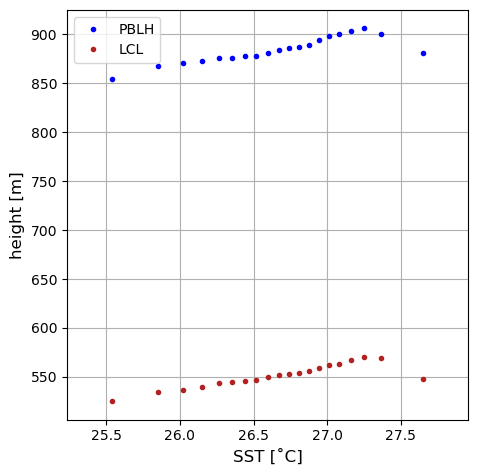

In [40]:
###### Figure
fig = plt.figure(figsize=(6., 6.), constrained_layout=True)
spec = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(spec[1:, :3]) # 2d distributions.

# ax1.plot(dist_sst-273.15, dist_PBLH, 'o', color='b', mfc='none')
ax1.plot(pdist_sst-273.15, pdist_PBLH, '.',color='b', label='PBLH')
# ax1.plot(dist_sst-273.15, dist_LCL, 'o', color='firebrick', mfc='none')
ax1.plot(pdist_sst-273.15, pdist_LCL, '.',color='firebrick', label='LCL')
ax1.legend()

# ax1.plot(dist_sst-273.15, dist_PBLH-dist_LCL, '.-', color='g', mfc='none')

ax1.set_ylabel('height [m]', fontsize=12); ax1.set_xlabel('SST [˚C]', fontsize=12); ax1.grid()
plt.xlim([ pdist_sst[0]-273.15 - (pdist_sst[1]-pdist_sst[0]),pdist_sst[-1]-273.15 + (pdist_sst[1]-pdist_sst[0]) ])

In [25]:
# PERC DISTRIBUTION
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/perc_dist/daily/'
# np.savetxt(path_bindist + 'pdist_sst_day.txt', pdist_sst)
np.savetxt(path_bindist + 'pdist_PBLH_sst_day.txt', pdist_PBLH)
np.savetxt(path_bindist + 'pdist_LCL_sst_day.txt', pdist_LCL)
np.savetxt(path_bindist + 'pstd_PBLH_sst_day.txt', pstd_PBLH)
np.savetxt(path_bindist + 'pstd_LCL_sst_day.txt', pstd_LCL)

In [19]:
# FB DISTRIBUTION (no point threshold)
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/fb_dist/daily/fullfield/'
np.savetxt(path_bindist + 'dist_sst_day.txt', dist_sst)
np.savetxt(path_bindist + 'dist_PBLH_sst_day.txt', dist_PBLH)
np.savetxt(path_bindist + 'dist_LCL_sst_day.txt', dist_LCL)
np.savetxt(path_bindist + 'std_err_PBLH_sst_day.txt', std_err_PBLH)
np.savetxt(path_bindist + 'std_err_LCL_sst_day.txt', std_err_LCL)
np.savetxt(path_bindist + 'npoint_PBLH_sst_day.txt', npoint_PBLH)
np.savetxt(path_bindist + 'npoint_LCL_sst_day.txt', npoint_LCL)

In [13]:
# DISTRIBUTION PBLH/LCL vs dSST bin - DAILY
perc_step = 5
nbins = int(100/perc_step) # Number of bins

In [ ]:
# PERC DISTRIBUTION
x = dsst_day.copy()
control = x.reshape(-1)
##### Perc distribution: PBLH
y = PBLH_day[:,:,:].copy()
variable = y.reshape(-1)
pdist_dsst, pdist_PBLH_dsst, pstd_PBLH_dsst, pstd_err_PBLH_dsst = perc_distribution(control, variable, nbins, perc_step)
##### Perc distribution: LCL
y = LCL_day[:,:,:].copy()
variable = y.reshape(-1)
pdist_dsst, pdist_LCL_dsst, pstd_LCL_dsst, pstd_err_LCL_dsst = perc_distribution(control, variable, nbins, perc_step)

In [23]:
# FIXED BIN DISTRIBUTION
x = dsst_day.copy()
control = x.reshape(-1)
##### Fixed bin distribution: PBLH
y = PBLH_day[:,:,:].copy()
variable = y.reshape(-1)
dist_dsst, dist_PBLH_dsst, std_err_PBLH_dsst, npoint_PBLH_dsst = fb_distribution_npoint(control, variable, nbins, perc_step)
##### Fixed bin distribution: LCL
y = LCL_day[:,:,:].copy()
variable = y.reshape(-1)
dist_dsst, dist_LCL_dsst, std_err_LCL_dsst, npoint_LCL_dsst = fb_distribution_npoint(control, variable, nbins, perc_step)

(-0.8635745704761542, 0.7660494511047653)

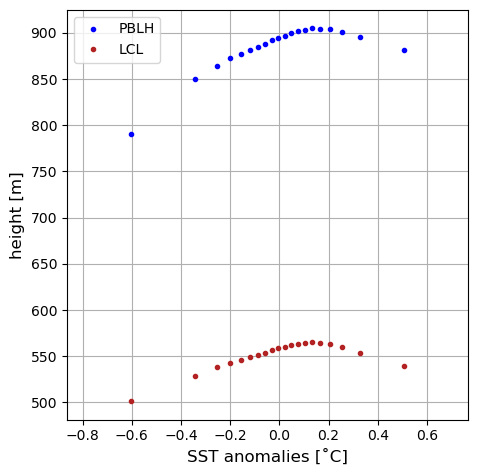

In [37]:
###### Figure
fig = plt.figure(figsize=(6., 6.), constrained_layout=True)
spec = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(spec[1:, :3]) # 2d distributions.

# ax1.plot(dist_dsst, dist_PBLH, 'o', color='b', mfc='none')
ax1.plot(pdist_dsst, pdist_PBLH_dsst, '.',color='b', label='PBLH')
# ax1.plot(dist_dsst, dist_LCL, 'o', color='firebrick', mfc='none')
ax1.plot(pdist_dsst, pdist_LCL_dsst, '.',color='firebrick', label='LCL')
ax1.legend()

# ax1.plot(pdist_dsst, pdist_PBLH_dsst-pdist_LCL_dsst, '.-', color='g', mfc='none')

ax1.set_ylabel('height [m]', fontsize=12); ax1.set_xlabel('SST anomalies [˚C]', fontsize=12); ax1.grid()
plt.xlim([ pdist_dsst[0] - (pdist_dsst[1]-pdist_dsst[0]),pdist_dsst[-1] + (pdist_dsst[1]-pdist_dsst[0]) ])

In [32]:
# PERC DISTRIBUTION
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/perc_dist/daily/'
# np.savetxt(path_bindist + 'pdist_dsst_day.txt', pdist_dsst)
np.savetxt(path_bindist + 'pdist_PBLH_dsst_day.txt', pdist_PBLH_dsst)
np.savetxt(path_bindist + 'pdist_LCL_dsst_day.txt', pdist_LCL_dsst)
np.savetxt(path_bindist + 'pstd_PBLH_dsst_day.txt', pstd_PBLH_dsst)
np.savetxt(path_bindist + 'pstd_LCL_dsst_day.txt', pstd_LCL_dsst)

In [24]:
# FB DISTRIBUTION (no point threshold)
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/fb_dist/daily/fullfield/'
np.savetxt(path_bindist + 'dist_dsst_day.txt', dist_dsst)
np.savetxt(path_bindist + 'dist_PBLH_dsst_day.txt', dist_PBLH_dsst)
np.savetxt(path_bindist + 'dist_LCL_dsst_day.txt', dist_LCL_dsst)
np.savetxt(path_bindist + 'std_err_PBLH_dsst_day.txt', std_err_PBLH_dsst)
np.savetxt(path_bindist + 'std_err_LCL_dsst_day.txt', std_err_LCL_dsst)
np.savetxt(path_bindist + 'npoint_PBLH_dsst_day.txt', npoint_PBLH_dsst)
np.savetxt(path_bindist + 'npoint_LCL_dsst_day.txt', npoint_LCL_dsst)

In [13]:
# DISTRIBUTION dPBLH/dLCL vs dSST bin - DAILY
perc_step = 5
nbins = int(100/perc_step) # Number of bins

In [ ]:
# PERC DISTRIBUTION
x = dsst_day.copy()
control = x.reshape(-1)
##### Perc distribution: PBLH
y = dPBLH_day[:,:,:].copy()
variable = y.reshape(-1)
pdist_dsst, pdist_dPBLH_dsst, pstd_dPBLH_dsst, pstd_err_dPBLH_dsst = perc_distribution(control, variable, nbins, perc_step)
##### Perc distribution: LCL
y = dLCL_day[:,:,:].copy()
variable = y.reshape(-1)
pdist_dsst, pdist_dLCL_dsst, pstd_dLCL_dsst, pstd_err_dLCL_dsst = perc_distribution(control, variable, nbins, perc_step)

In [25]:
# FIXED BIN DISTRIBUTION
x = dsst_day.copy()
control = x.reshape(-1)
##### Fixed bin distribution: PBLH
y = dPBLH_day[:,:,:].copy()
variable = y.reshape(-1)
dist_dsst, dist_dPBLH_dsst, std_err_dPBLH_dsst, npoint_dPBLH_dsst = fb_distribution_npoint(control, variable, nbins, perc_step)
##### Fixed bin distribution: LCL
y = dLCL_day[:,:,:].copy()
variable = y.reshape(-1)
dist_dsst, dist_dLCL_dsst, std_err_dLCL_dsst, npoint_dLCL_dsst = fb_distribution_npoint(control, variable, nbins, perc_step)

(-0.8635745704761542, 0.7660494511047653)

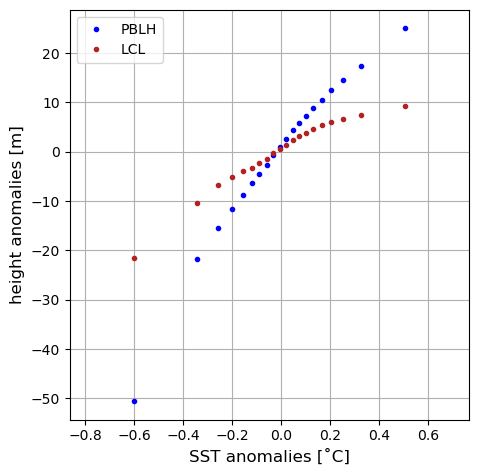

In [36]:
###### Figure
fig = plt.figure(figsize=(6., 6.), constrained_layout=True)
spec = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(spec[1:, :3]) # 2d distributions.

ax1.plot(pdist_dsst, pdist_dPBLH_dsst, '.',color='b', label='PBLH')
ax1.plot(pdist_dsst, pdist_dLCL_dsst, '.',color='firebrick', label='LCL')
ax1.legend()

ax1.set_ylabel('height anomalies [m]', fontsize=12); ax1.set_xlabel('SST anomalies [˚C]', fontsize=12); ax1.grid()
plt.xlim([ pdist_dsst[0] - (pdist_dsst[1]-pdist_dsst[0]),pdist_dsst[-1] + (pdist_dsst[1]-pdist_dsst[0]) ])

In [38]:
# PERC DISTRIBUTION
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/perc_dist/daily/'
# np.savetxt(path_bindist + 'pdist_dsst_day.txt', pdist_dsst)
np.savetxt(path_bindist + 'pdist_dPBLH_dsst_day.txt', pdist_dPBLH_dsst)
np.savetxt(path_bindist + 'pdist_dLCL_dsst_day.txt', pdist_dLCL_dsst)
np.savetxt(path_bindist + 'pstd_dPBLH_dsst_day.txt', pstd_dPBLH_dsst)
np.savetxt(path_bindist + 'pstd_dLCL_dsst_day.txt', pstd_dLCL_dsst)

In [26]:
# FB DISTRIBUTION (no point threshold)
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/fb_dist/daily/fullfield/'
np.savetxt(path_bindist + 'dist_dsst_day.txt', dist_dsst)
np.savetxt(path_bindist + 'dist_dPBLH_dsst_day.txt', dist_dPBLH_dsst)
np.savetxt(path_bindist + 'dist_dLCL_dsst_day.txt', dist_dLCL_dsst)
np.savetxt(path_bindist + 'std_err_dPBLH_dsst_day.txt', std_err_dPBLH_dsst)
np.savetxt(path_bindist + 'std_err_dLCL_dsst_day.txt', std_err_dLCL_dsst)
np.savetxt(path_bindist + 'npoint_dPBLH_dsst_day.txt', npoint_dPBLH_dsst)
np.savetxt(path_bindist + 'npoint_dLCL_dsst_day.txt', npoint_dLCL_dsst)

In [ ]:
# HOURLY DATA

In [16]:
# hourly varaibles
# select sst, q2, U, PBLH
sst = ds['SST'].values*seamask
PBLH = ds['PBLH'].values*seamask

In [17]:
# read HOURLY LCL
LCL_file = '/media/fabien/DAGOBAH1/WRF_EUREC4A/CNT/FEB/LCL.nc'
ds_lcl = xr.open_dataset(LCL_file)

In [18]:
LCL = ds_lcl['LCL'].values*seamask

In [19]:
# compute anomalies hourly data
s = 50
dsst = np.zeros(sst.shape)
dPBLH = np.zeros(PBLH.shape); dLCL = np.zeros(LCL.shape)
for t in range(0,sst.shape[0]):
    if t % 100 == 0:
        print(t)
    # upscale using gaussian filter
    sst_ave = gm.nan_gaussian_filter(sst[t],s)*seamask
    dsst[t] = sst[t] - sst_ave
    PBLH_ave = gm.nan_gaussian_filter(PBLH[t],s)*seamask
    dPBLH[t] = PBLH[t] - PBLH_ave
    LCL_ave = gm.nan_gaussian_filter(LCL[t],s)*seamask
    dLCL[t] = LCL[t] - LCL_ave

0
100
200
300
400
500
600


In [20]:
# DISTRIBUTION dPBLH/dLCL vs dSST bin - HOURLY
thrsld_n = 100
perc_step = 5
nbins = int(100/perc_step) # Number of bins
x = dsst.copy()
control = x.reshape(-1)
##### Perc distribution: dPBLH
y = dPBLH[:,:,:].copy()
variable = y.reshape(-1)
pdist_dsst, pdist_dPBLH, pstd_err_dPBLH = perc_distribution(control, variable, nbins, perc_step)
##### Fixed bin distribution: dPBLH
dist_dsst, dist_dPBLH, std_err_dPBLH, npoint_dPBLH = fb_distribution_mod(control, variable, nbins, thrsld_n, perc_step)
##### Perc distribution: dLCL
y = dLCL[:,:,:].copy()
variable = y.reshape(-1)
pdist_dsst, pdist_dLCL, pstd_err_dLCL = perc_distribution(control, variable, nbins, perc_step)
##### Fixed bin distribution: dLCL
dist_dsst, dist_dLCL, std_err_dLCL, npoint_dLCL = fb_distribution_mod(control, variable, nbins, thrsld_n, perc_step)

(-1.710400590329404, 1.412905502207133)

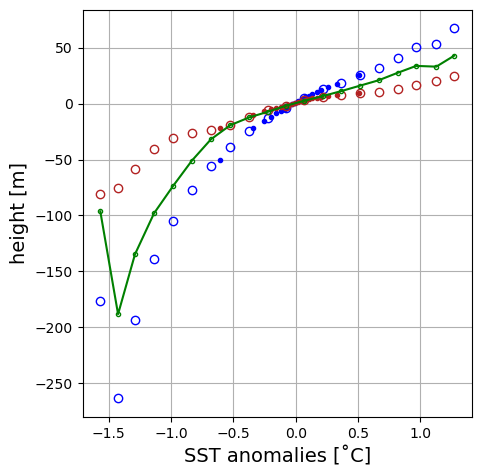

In [21]:
###### Figure
fig = plt.figure(figsize=(6., 6.), constrained_layout=True)
spec = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(spec[1:, :3]) # 2d distributions.

# ax1.errorbar(dist_dsst, dist_dPBLH, std_err_dPBLH, fmt='o', color='b', mfc='none')
# ax1.errorbar(pdist_dsst, pdist_dPBLH, pstd_err_dPBLH, fmt='.',color='b')
# ax1.errorbar(dist_dsst, dist_dLCL, std_err_dLCL, fmt='o', color='firebrick', mfc='none')
# ax1.errorbar(pdist_dsst, pdist_dLCL, pstd_err_dLCL, fmt='.',color='firebrick')

ax1.plot(dist_dsst, dist_dPBLH, 'o', color='b', mfc='none')
ax1.plot(pdist_dsst, pdist_dPBLH, '.',color='b')
ax1.plot(dist_dsst, dist_dLCL, 'o', color='firebrick', mfc='none')
ax1.plot(pdist_dsst, pdist_dLCL, '.',color='firebrick')

ax1.plot(dist_dsst, dist_dPBLH-dist_dLCL, '.-', color='g', mfc='none')

ax1.set_ylabel('height [m]', fontsize=12); ax1.set_xlabel('SST anomalies [˚C]', fontsize=12); ax1.grid()
plt.xlim([ dist_dsst[0] - + (dist_dsst[1]-dist_dsst[0]),dist_dsst[-1] + (dist_dsst[1]-dist_dsst[0]) ])

In [24]:
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/'
# PERC DISTRIBUTION
np.savetxt(path_bindist + 'pdist_dsst.txt', pdist_dsst)
np.savetxt(path_bindist + 'pdist_dPBLH.txt', pdist_dPBLH)
np.savetxt(path_bindist + 'pdist_dLCL.txt', pdist_dLCL)
np.savetxt(path_bindist + 'pstd_err_dPBLH.txt', pstd_err_dPBLH)
np.savetxt(path_bindist + 'pstd_err_dLCL.txt', pstd_err_dLCL)
# FB DISTRIBUTION (no point threshold)
np.savetxt(path_bindist + 'dist_dsst.txt', dist_dsst)
np.savetxt(path_bindist + 'dist_dPBLH.txt', dist_dPBLH)
np.savetxt(path_bindist + 'dist_dLCL.txt', dist_dLCL)
np.savetxt(path_bindist + 'std_err_dPBLH.txt', std_err_dPBLH)
np.savetxt(path_bindist + 'std_err_dLCL.txt', std_err_dLCL)
np.savetxt(path_bindist + 'npoint_dPBLH.txt', npoint_dPBLH)
np.savetxt(path_bindist + 'npoint_dLCL.txt', npoint_dLCL)

In [88]:
# corr length
L = 80
nskip = int(L/3)
nt = int(3)
nbin = 50

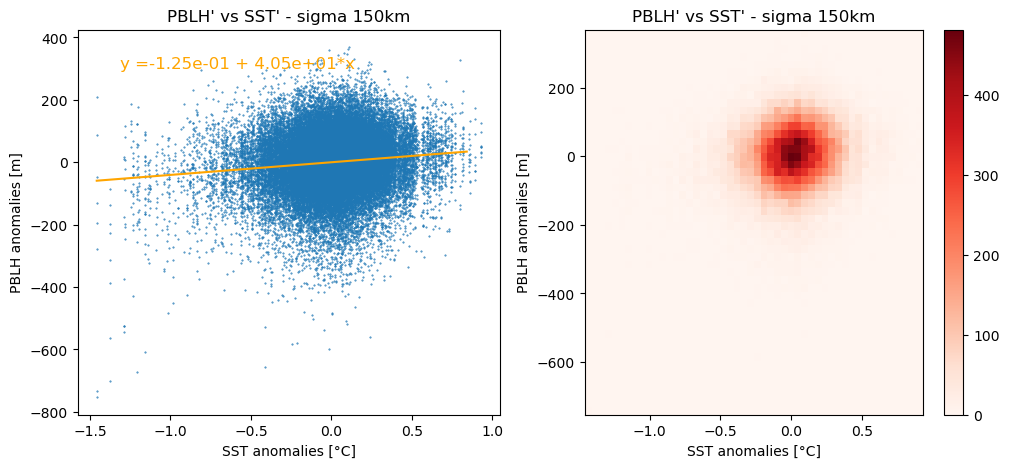

In [100]:
# linear regression PBLH vs SST
x = dsst[::nt,::nskip,::nskip].copy()
# y = dPBLH[::nt,::nskip,::nskip].copy()
y = (dPBLH - dLCL)[::nt,::nskip,::nskip].copy()
linreg_res, corr_coeff, p_value = slopes_r_p(x,y)

fig = plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
# scatterplot lin regression 
title = "PBLH' vs SST' - sigma "
xlabel = 'SST anomalies [°C]'; ylabel = "PBLH anomalies [m]"
fig1 = scatterplot_fit(x, y, linreg_res, s, title, xlabel, ylabel, fig)
# histogram 2d 
plt.subplot(1,2,2)
fig2 = hist2d(x, y, s, nbin, title, xlabel, ylabel, fig)

In [ ]:
# PLOT DATA

In [ ]:
##############
# BOXPLOT
##############

In [85]:
# BOXPLOT
def box_plot(data, labels, edge_color, fill_color, ax):
    medianprops = dict(linestyle='-', linewidth=1, color=edge_color)
    meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor=edge_color, markersize=4)
    flierprops = dict(marker='o', markeredgecolor=edge_color, markersize=6,
                  linestyle='none')
    
    bp = ax.boxplot(data, labels=labels, medianprops=medianprops, flierprops=flierprops, \
                    meanprops=meanpointprops, showmeans=True, patch_artist=True)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
        
    return bp

def box_plot_pos(data, offset, labels, edge_color, fill_color, ax):
    medianprops = dict(linestyle='-', linewidth=1, color=edge_color)
    meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor=edge_color, markersize=4)
    flierprops = dict(marker='o', markeredgecolor=edge_color, markersize=6,
                  linestyle='none')
    
    pos = np.arange(len(labels))+offset
    
    bp = ax.boxplot(data, positions= pos, labels=labels, medianprops=medianprops, flierprops=flierprops, \
                    meanprops=meanpointprops, showmeans=True, patch_artist=True)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
        
    return bp

In [62]:
# build sst perc classes
perc = np.arange(10,100,10)
sst_day_perc = np.zeros(len(perc))
dsst_day_perc = np.zeros(len(perc))

for i in range(0,len(perc)):
    sst_day_perc[i] = np.nanpercentile(sst_day,perc[i])
    dsst_day_perc[i] = np.nanpercentile(dsst_day,perc[i])

In [92]:
bin_PBLH_sst = []; bin_LCL_sst = []
bin_PBLH_dsst = []; bin_LCL_dsst = []
bin_dPBLH_dsst = []; bin_dLCL_dsst = []
labels = []; dlabels = []
for i in range(0,len(perc)):
    if i == 0:
        pblh_sst = PBLH_day[sst_day < sst_day_perc[i]]; lcl_sst = LCL_day[sst_day < sst_day_perc[i]]
        pblh_dsst = PBLH_day[dsst_day < dsst_day_perc[i]]; lcl_dsst = LCL_day[dsst_day < dsst_day_perc[i]]
        dpblh_dsst = dPBLH_day[dsst_day < dsst_day_perc[i]]; dlcl_dsst = dLCL_day[dsst_day < dsst_day_perc[i]]
    else:
        pblh_sst = PBLH_day[(sst_day >= sst_day_perc[i-1]) & (sst_day < sst_day_perc[i])]
        pblh_dsst = PBLH_day[(dsst_day >= dsst_day_perc[i-1]) & (dsst_day < dsst_day_perc[i])]
        dpblh_dsst = dPBLH_day[(dsst_day >= dsst_day_perc[i-1]) & (dsst_day < dsst_day_perc[i])]
        lcl_sst = LCL_day[(sst_day >= sst_day_perc[i-1]) & (sst_day < sst_day_perc[i])]
        lcl_dsst = LCL_day[(dsst_day >= dsst_day_perc[i-1]) & (dsst_day < dsst_day_perc[i])]
        dlcl_dsst = dLCL_day[(dsst_day >= dsst_day_perc[i-1]) & (dsst_day < dsst_day_perc[i])]
    # create lists
    bin_PBLH_sst.append(pblh_sst); bin_LCL_sst.append(lcl_sst)
    bin_PBLH_dsst.append(pblh_dsst); bin_LCL_dsst.append(lcl_dsst)
    bin_dPBLH_dsst.append(dpblh_dsst); bin_dLCL_dsst.append(dlcl_dsst)
    labels.append(str(np.round(sst_day_perc[i]-273.15,2)))
    dlabels.append(str(np.round(dsst_day_perc[i],2)))
# adding last class, when data > 90perc sst
pblh_sst = PBLH_day[sst_day >= sst_day_perc[-1]]; lcl_sst = LCL_day[sst_day >= sst_day_perc[-1]]
pblh_dsst = PBLH_day[dsst_day >= dsst_day_perc[-1]]; lcl_dsst = LCL_day[dsst_day >= dsst_day_perc[-1]]
dpblh_dsst = dPBLH_day[dsst_day >= dsst_day_perc[-1]]; dlcl_dsst = dLCL_day[dsst_day >= dsst_day_perc[-1]]
bin_PBLH_sst.append(pblh_sst); bin_LCL_sst.append(lcl_sst)
bin_PBLH_dsst.append(pblh_dsst); bin_LCL_dsst.append(lcl_dsst)
bin_dPBLH_dsst.append(dpblh_dsst); bin_dLCL_dsst.append(dlcl_dsst)
labels.append(' '); dlabels.append(' ')       

Text(0, 0.5, 'height anom [m]')

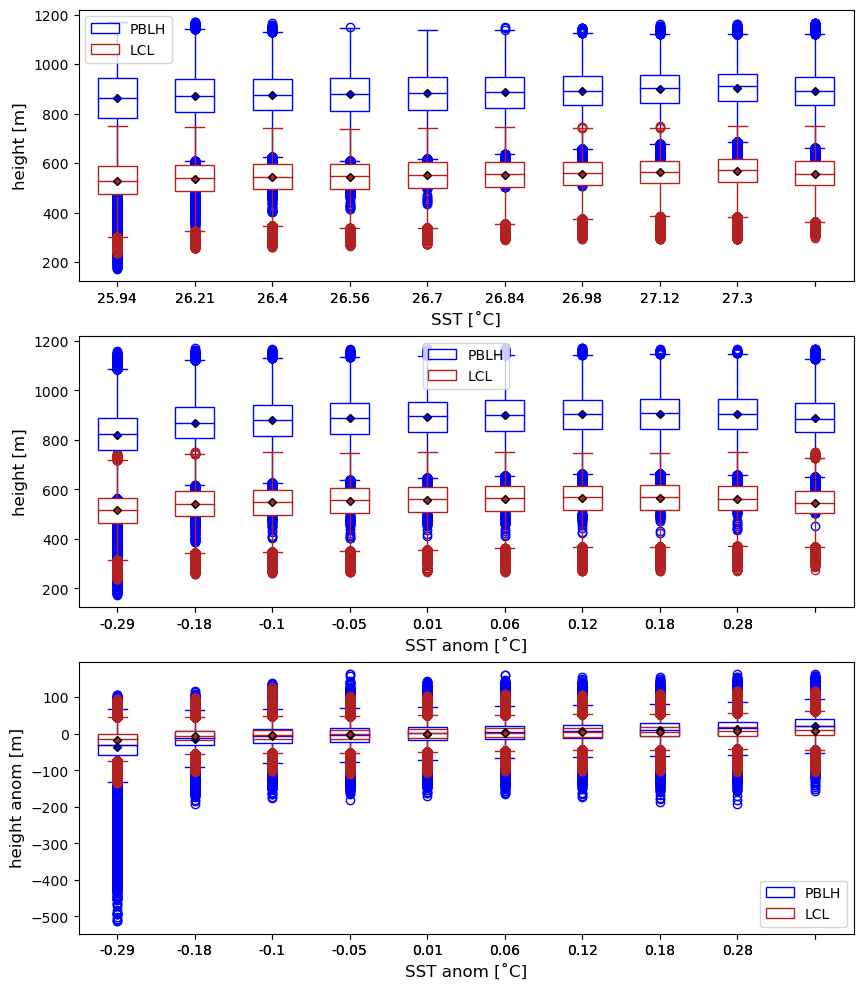

In [94]:
# BOXPLOT SOVRAPPOSTO
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 12))

bp1 = box_plot(bin_PBLH_sst, labels, 'blue', 'white', ax1)
bp2 = box_plot(bin_LCL_sst, labels, 'firebrick', 'white', ax1)
ax1.legend([bp1["boxes"][0], bp2["boxes"][0]], ['PBLH', 'LCL'])
ax1.set_xlabel('SST [˚C]', fontsize=12); ax1.set_ylabel('height [m]', fontsize=12)

bp1 = box_plot(bin_PBLH_dsst, dlabels, 'blue', 'white', ax2)
bp2 = box_plot(bin_LCL_dsst, dlabels, 'firebrick', 'white', ax2)
ax2.legend([bp1["boxes"][0], bp2["boxes"][0]], ['PBLH', 'LCL'])
ax2.set_xlabel('SST anom [˚C]', fontsize=12); ax2.set_ylabel('height [m]', fontsize=12)

bp1 = box_plot(bin_dPBLH_dsst, dlabels, 'blue', 'white', ax3)
bp2 = box_plot(bin_dLCL_dsst, dlabels, 'firebrick', 'white', ax3)
ax3.legend([bp1["boxes"][0], bp2["boxes"][0]], ['PBLH', 'LCL'])
ax3.set_xlabel('SST anom [˚C]', fontsize=12); ax3.set_ylabel('height anom [m]', fontsize=12)

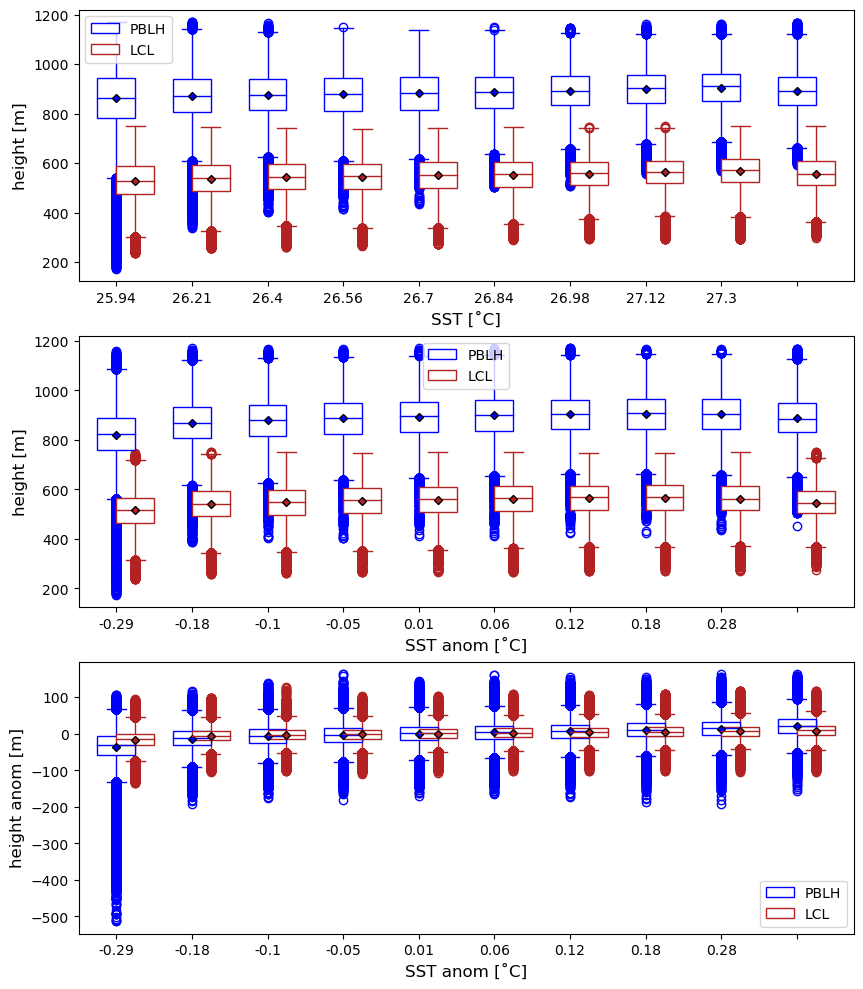

In [97]:
# BOXPLOT AFFIANCATO
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 12))

offs = 0.25

bp1 = box_plot_pos(bin_PBLH_sst, 0, labels, 'blue', 'white', ax1)
bp2 = box_plot_pos(bin_LCL_sst, offs, labels, 'firebrick', 'white', ax1)
ax1.legend([bp1["boxes"][0], bp2["boxes"][0]], ['PBLH', 'LCL'])
ax1.set_xlabel('SST [˚C]', fontsize=12); ax1.set_ylabel('height [m]', fontsize=12)
ax1.set_xticks(np.arange(len(labels)))

bp1 = box_plot_pos(bin_PBLH_dsst, 0, dlabels, 'blue', 'white', ax2)
bp2 = box_plot_pos(bin_LCL_dsst, offs, dlabels, 'firebrick', 'white', ax2)
ax2.legend([bp1["boxes"][0], bp2["boxes"][0]], ['PBLH', 'LCL'])
ax2.set_xlabel('SST anom [˚C]', fontsize=12); ax2.set_ylabel('height [m]', fontsize=12)
ax2.set_xticks(np.arange(len(labels)))

bp1 = box_plot_pos(bin_dPBLH_dsst, 0, dlabels, 'blue', 'white', ax3)
bp2 = box_plot_pos(bin_dLCL_dsst, offs, dlabels, 'firebrick', 'white', ax3)
ax3.legend([bp1["boxes"][0], bp2["boxes"][0]], ['PBLH', 'LCL'])
ax3.set_xlabel('SST anom [˚C]', fontsize=12); ax3.set_ylabel('height anom [m]', fontsize=12)
ax3.set_xticks(np.arange(len(labels)))

In [119]:
# HOURLY

In [133]:
bin_dPBLH = [dPBLH[dsst < -1.5], \
            dPBLH[(dsst >= -1.5) & (dsst < -1)], \
            dPBLH[(dsst >= -1) & (dsst < -0.5)], \
            dPBLH[(dsst >= -0.5) & (dsst < 0)], \
            dPBLH[(dsst >= 0) & (dsst < 0.5)], \
            dPBLH[(dsst >= 0.5) & (dsst < 1)], \
            dPBLH[dsst >= 1]]
bin_dLCL = [dLCL[dsst < -1.5], \
            dLCL[(dsst >= -1.5) & (dsst < -1)], \
            dLCL[(dsst >= -1) & (dsst < -0.5)], \
            dLCL[(dsst >= -0.5) & (dsst < 0)], \
            dLCL[(dsst >= 0) & (dsst < 0.5)], \
            dLCL[(dsst >= 0.5) & (dsst < 1)], \
            dLCL[dsst >= 1]]

dlabels = ['-1.5', '-1', '-0.5', '0', '0.5', '1', '1+']

Text(0, 0.5, 'height [m]')

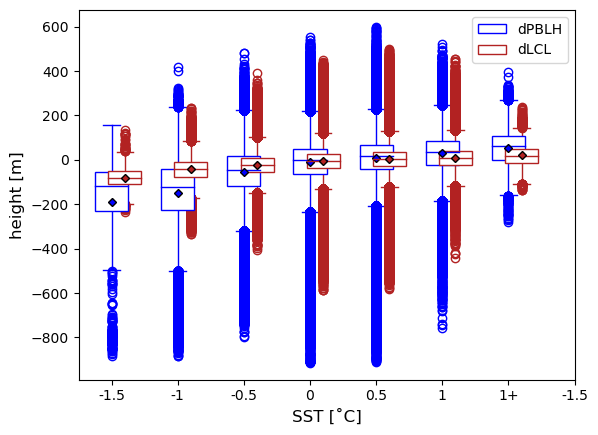

In [134]:
fig, ax = plt.subplots()
bp1 = box_plot_pos(bin_dPBLH, 0, dlabels, 'blue', 'white')
bp2 = box_plot_pos(bin_dLCL, 0.2, dlabels, 'firebrick', 'white')
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['dPBLH', 'dLCL'])
ax.set_xticks(np.arange(len(labels)))
ax.set_xlabel('SST [˚C]', fontsize=12); ax.set_ylabel('height [m]', fontsize=12)

In [ ]:
# READ DATA

In [ ]:
# DAILY
# PERC DISTRIBUTION
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/perc_dist/daily/'
pdist_sst = np.loadtxt(path_bindist + 'pdist_sst.txt')
pdist_PBLH = np.loadtxt(path_bindist + 'pdist_PBLH.txt')
pdist_LCL = np.loadtxt(path_bindist + 'pdist_LCL.txt')
pstd_err_PBLH = np.loadtxt(path_bindist + 'pstd_PBLH.txt')
pstd_err_LCL = np.loadtxt(path_bindist + 'pstd_LCL.txt')
# FB DISTRIBUTION (no point threshold)
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/fb_dist/daily/'
dist_sst = np.loadtxt(path_bindist + 'dist_sst.txt')
dist_PBLH = np.loadtxt(path_bindist + 'dist_PBLH.txt')
dist_LCL = np.loadtxt(path_bindist + 'dist_LCL.txt')
std_err_PBLH = np.loadtxt(path_bindist + 'std_err_PBLH.txt')
std_err_LCL = np.loadtxt(path_bindist + 'std_err_LCL.txt')
npoint_PBLH = np.loadtxt(path_bindist + 'npoint_PBLH.txt')
npoint_LCL = np.loadtxt(path_bindist + 'npoint_LCL.txt')

In [ ]:
# HOURLY
# PERC DISTRIBUTION
pdist_dsst = np.loadtxt(path_bindist + 'pdist_dsst.txt')
pdist_dPBLH = np.loadtxt(path_bindist + 'pdist_dPBLH.txt')
pdist_dLCL = np.loadtxt(path_bindist + 'pdist_dLCL.txt')
pstd_err_dPBLH = np.loadtxt(path_bindist + 'pstd_err_dPBLH.txt')
pstd_err_dLCL = np.loadtxt(path_bindist + 'pstd_err_dLCL.txt')
# FB DISTRIBUTION (no point threshold)
dist_dsst = np.loadtxt(path_bindist + 'dist_dsst.txt')
dist_dPBLH = np.loadtxt(path_bindist + 'dist_dPBLH.txt')
dist_dLCL = np.loadtxt(path_bindist + 'dist_dLCL.txt')
std_err_dPBLH = np.loadtxt(path_bindist + 'std_err_dPBLH.txt')
std_err_dLCL = np.loadtxt(path_bindist + 'std_err_dLCL.txt')
npoint_dPBLH = np.loadtxt(path_bindist + 'npoint_dPBLH.txt')
npoint_dLCL = np.loadtxt(path_bindist + 'npoint_dLCL.txt')